In [34]:
import keras
import cv2
import h5py
from collections import Counter
from keras import backend as K
from keras.models import Model
from keras.utils import np_utils
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img
from keras.layers.normalization import BatchNormalization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report

In [2]:
np.random.seed(12345)

In [3]:
def cut_window_by_coordinate(img, left_x, upper_y, window_width, window_height):
    """ 
    座標を指定することで、画像から矩形領域をカットする関数
    left_x : 左上のx座標
    upper_y : 左上のy座標
    window_width : 矩形の幅
    window_height : 矩形の高さ
    """
    # 窓画像の左上座標
    x, y = left_x, upper_y
    # 窓画像の幅・高さ
    w, h = window_width, window_height
    # 入力画像から窓画像を切り取り
    roi = img[y:y+h, x:x+w]    
    return roi

In [4]:
# パッチのサイズの情報
window_width = 100
window_height = 100   
slide_width = 10

In [5]:
# それぞれの画像について腫瘍情報のテーブルを作る
#UT007に関してはもう一度みる必要あり
pic_info = pd.DataFrame({
                'patient_id' :        ['UT001', 'UT001', 'UT001', 'UT010', 'UT010', 'UT010',  'UT010', 'UT003', 'UT003', 'UT003', 'UT007', 'UT007', 'UT007', 'UT008', 'UT008', 'UT008', 'UT009', 'UT009', 'UT009','UT011','UT011','UT011'],
                'patient_sub_height': [  '100',   '200',   '300',   '900',  '1000',  '1100',   '1200',  '1300',  '1400',  '1500',   '700',   '800',   '900',   '600',   '700',   '800',  '1500',  '1600',  '1700',  '600',  '700',  '800'],
                'patient_sub_speed':  [ '1480',  '1480',  '1480',  '1510',  '1510',  '1510',   '1510',  '1480',  '1480',  '1480',  '1523',  '1523',  '1523',  '1521',  '1521',  '1521',  '1518',  '1518',  '1518', '1523', '1523', '1523'],
                'tumor_left_x' :      [    195,     201,     198,     310,     310,     310,     310,      295,     290,    290,      180,     200,     195,     200,     200,     200,     132,     132,     127,    170,   175,     172],
                'tumor_upper_y' :     [    205,     208,     200,     225,     225,     225,     230,      300,     298,    300,      230,     250,     240,     220,     220,     220,     270,     270,     270,    245,   250,     253],
                'tumor_width' :       [     50,      50,      50,      70,      50,      45,      45,       50,      50,     50,       80,      60,      70,      70,      70,      70,      50,      50,      50,     55,    55,      45],
                'tumor_height' :      [     45,      45,      45,      45,      70,      50,      50,       35,      30,     40,       80,      60,      70,      40,      40,      40,      55,      55,      55,     55,    55,      45],
                'default_left_x' :    [    100,     100,     100,     150,    150,      150,     150,      100,     100,    100,      100,     100,     100,     100,     100,     100,     100,     100,      100,    100,   100,    100],
                'default_upper_y' :   [    100,     100,     100,     100,    100,      100,     100,      100,     100,    100,      200,     200,     200,     100,     100,     100,     100,     100,      100,    100,   100,    100],
                'max_left_x' :        [    340,     340,     340,     340,    340,      340,     340,      340,     340,    340,      220,     220,     220,     340,     340,     340,     340,     340,      340,    250,   250,    250],
                'max_upper_y' :       [    340,     340,     340,     340,    340,      340,     340,      340,     340,    340,      280,     280,     280,     240,     340,     340,     340,     340,      340,    300,   300,    300],
                'file_path' : ['./data/all_data/tumor/P_UT001_20161226_153444_100_speed1480_GCF010_comp8.bmp',
                               './data/all_data/tumor/P_UT001_20161226_153500_200_speed1480_GCF010_comp8.bmp',
                               './data/all_data/tumor/P_UT001_20161226_153514_300_speed1480_GCF010_comp8.bmp',
                               './data/all_data/tumor/N_UT010_20170428_141903_900_speed1510_GCF10_comp8_max02.bmp',
                               './data/all_data/tumor/N_UT010_20170428_141918_1000_speed1510_GCF10_comp8_max02.bmp',
                               './data/all_data/tumor/N_UT010_20170428_141932_1100_speed1510_GCF10_comp8_max02.bmp',
                               './data/all_data/tumor/N_UT010_20170428_141946_1200_speed1510_GCF10_comp8_max02.bmp',
                               './data/all_data/tumor/UT003_20170120_155150_1300_speed1480_GCF10_comp8.bmp',
                               './data/all_data/tumor/UT003_20170120_155205_1400_speed1480_GCF10_comp8.bmp',
                               './data/all_data/tumor/UT003_20170120_155219_1500_speed1480_GCF10_comp8.bmp',
                               './data/all_data/tumor/UT007_20170303_120722_700_speed1523.985_gcf10_comp8_1490_binarySpeed.bmp',
                               './data/all_data/tumor/UT007_20170303_120736_800_speed1523.985_gcf10_comp8_1490_binarySpeed.bmp',
                               './data/all_data/tumor/UT007_20170303_120750_900_speed1523.985_gcf10_comp8_1490_binarySpeed.bmp',
                               './data/all_data/tumor/N_UT_008_20170407_144338_600_speed1521.935_gcf10_comp8_1400_binarySpeed.bmp',
                               './data/all_data/tumor/N_UT_008_20170407_144352_700_speed1521.935_gcf10_comp8_1400_binarySpeed.bmp',
                               './data/all_data/tumor/N_UT_008_20170407_144407_800_speed1521.935_gcf10_comp8_1400_binarySpeed.bmp',
                               './data/all_data/tumor/UT009_20170421_135409_1500_speed1518.414_gcf10_comp8_1395_binarySpeed.bmp',
                               './data/all_data/tumor/UT009_20170421_135424_1600_speed1518.414_gcf10_comp8_1395_binarySpeed.bmp',
                               './data/all_data/tumor/UT009_20170421_135438_1700_speed1518.414_gcf10_comp8_1395_binarySpeed.bmp',
                               './data/all_data/tumor/UT011_20170512_141428_600_speed1523.434_gcf10_comp8_1460_binarySpeed.bmp',
                               './data/all_data/tumor/UT011_20170512_141441_700_speed1523.434_gcf10_comp8_1460_binarySpeed.bmp',
                               './data/all_data/tumor/UT011_20170512_141455_800_speed1523.434_gcf10_comp8_1460_binarySpeed.bmp',]
                }, index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [6]:
sample_size = len(pic_info)  # 2以上である必要あり

In [7]:
j = 0
X = []

patch = []
p_id = []
label = []
x_y_label = []

for j in range(0, sample_size, 1):

    patient_id = pic_info['patient_id'][j]
    tumor_left_x = pic_info['tumor_left_x'][j]
    tumor_upper_y = pic_info['tumor_upper_y'][j]
    tumor_width = pic_info['tumor_width'][j]
    tumor_height = pic_info['tumor_height'][j]
    default_left_x = pic_info['default_left_x'][j]
    default_upper_y = pic_info['default_upper_y'][j]
    max_left_x = pic_info['max_left_x'][j]
    max_upper_y = pic_info['max_upper_y'][j]
    file_path = pic_info['file_path'][j]
    
    img = cv2.imread(file_path)       

    # 写真の中の(100, 100) から (440, 440)までの間でパッチを作る
    # パッチの大きさは100 * 100にする
    # スライド幅は20ずつにする
    # sliding windowにより作られるパッチの数は (340 - 100) / 20 * (340 - 100) / 20 = 144個
    # それが5つぶんで 144 * 5 = 720個
            
    i = 0

    for left_x in range(default_left_x, max_left_x, slide_width):
        for upper_y in range(default_upper_y, max_upper_y, slide_width):
            img_patch = cut_window_by_coordinate(img, left_x, upper_y, window_width, window_height)
            
            X.append(img_to_array(img_patch/255.0))
            
            # 癌が含まれているかの判定 完全に領域を含んでいる場合のみ検出する
            if tumor_left_x >= left_x and tumor_left_x + tumor_width <= left_x + window_width and tumor_upper_y >= upper_y and tumor_upper_y + tumor_height <= upper_y + window_height:
                contains_tumor = 1 
            else: contains_tumor = 0
            
            # 角フラグを立てる
            if left_x == default_left_x or left_x == max_left_x - slide_width:
                corner_flag = 1
            else: corner_flag = 0
            
            # patch_idの付与 一応
            patch_id = patient_id + str(left_x) + str(upper_y)      
            
            #画像とlabelの対応を確実に行う
            x_y_set = (img_to_array(img_patch/255.0), contains_tumor, patient_id, patch_id)
            
            p_id.append(patient_id)
            patch.append(patch_id)
            label.append(contains_tumor)
            x_y_label.append(x_y_set)
            
            i += 1

In [8]:
train_cancer=[]
train_not_cancer=[]
test_cancer=[]
test_not_cancer=[]

for i in range(len(x_y_label)):
    if x_y_label[i][1] == 0 and x_y_label[i][2] != "UT001" :
        train_not_cancer.append(x_y_label[i])
    elif x_y_label[i][1] == 1 and x_y_label[i][2] != "UT001" :
        train_cancer.append(x_y_label[i])
    elif x_y_label[i][1] == 0 and x_y_label[i][2] == "UT001" :
        test_not_cancer.append(x_y_label[i])
    elif x_y_label[i][1] == 1 and x_y_label[i][2] == "UT001" :
        test_cancer.append(x_y_label[i])

#ラベルの比率合わせ
train_length_min = min([len(train_cancer), len(train_not_cancer)])
test_length_min = min([len(test_cancer), len(test_not_cancer)])

train_cancer = random.sample(train_cancer, train_length_min)
train_not_cancer = random.sample(train_not_cancer, train_length_min)
test_cancer = random.sample(test_cancer, test_length_min)
test_not_cancer = random.sample(test_not_cancer, test_length_min) 

train_cancer.extend(train_not_cancer)
test_cancer.extend(test_not_cancer)

In [9]:
print(len(train_cancer))
print(len(train_not_cancer))
print(len(test_cancer))
print(len(test_not_cancer))

996
498
170
85


In [10]:
X_train, Y_train, _, _, = list(zip(*train_cancer))
X_test, Y_test, _, _, = list(zip(*test_cancer))

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
                                                          
Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)

from keras.utils.np_utils import to_categorical
x_train = np.array(X_train).astype('float32')
y_train = to_categorical(Y_train, 2)

x_test = np.array(X_test).astype('float32')
y_test = to_categorical(Y_test, 2)

### 切り出した画像の確認
- そもそもラベル作成がうまくできていないかもしれない（根本的にindexがずれている可能性）
- もしくはバッチのサイズがでかすぎるかもしれない・・・

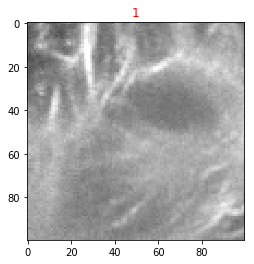

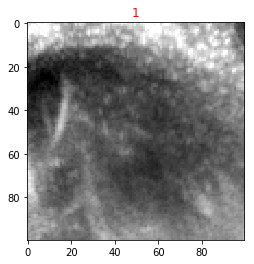

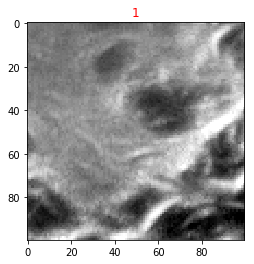

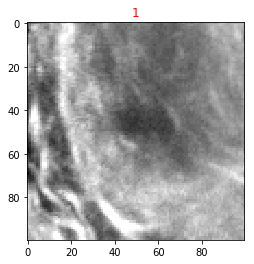

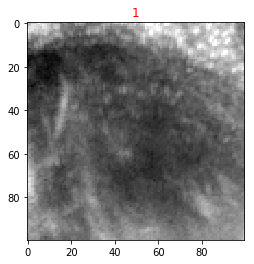

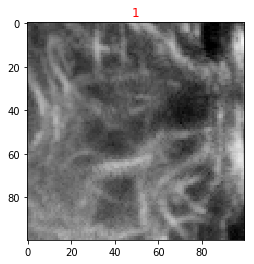

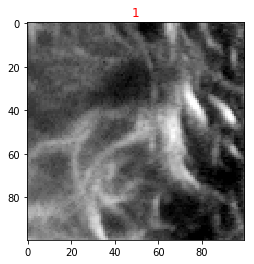

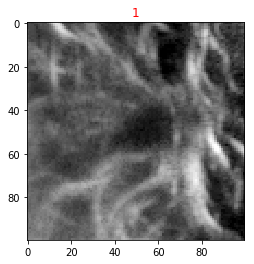

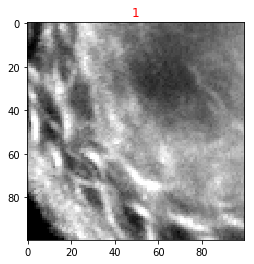

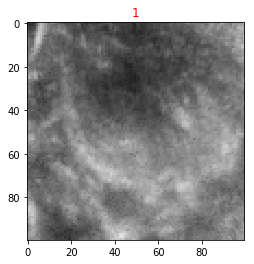

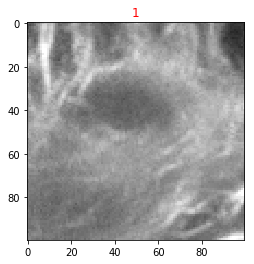

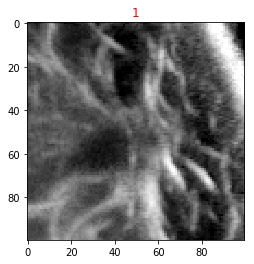

KeyboardInterrupt: 

In [37]:
for i in range(len(x_train)):
    plt.imshow(x_train[i], cmap = 'gray', vmin = 0, vmax = 255, interpolation = 'none')
    plt.title(Y_train[i], color="red")
    plt.show()

In [11]:
img_rows, img_cols = 100, 100

In [12]:
# shapeの調整
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 1)

In [13]:
val_x_train, val_x_test, val_y_train, val_y_test = train_test_split(x_train, y_train, test_size=0.5, random_state=123)

### モデルの構築

- 各層のActivation は 'relu' などがいい
- 最後のActivation は 'softmax' や 'tanh' などがいい　?

→       2値分類：Actination = 'sigmoid', loss = 'cross_entoropy'
    多クラス分類：Actination = 'softmax', loss = 'cross_entoropy'
(http://www.renom.jp/ja/notebooks/basic/lossfunction/notebook.html)
- Dropout と batch正則化 は 同時にやらないほうがいい ? (https://arxiv.org/pdf/1801.05134.pdf)



In [51]:
n_filter = 32
n_filter2 = 64
size_filter = 20
size_filter2 = 10
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter2, size_filter2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter2, size_filter2)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [52]:
print('model')
print(model.summary())

model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 32)      38432     
_________________________________________________________________
activation_7 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 81, 81, 32)        409632    
_________________________________________________________________
activation_8 (Activation)    (None, 81, 81, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 81, 81, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 40, 40, 64)        204864    
____

### 学習

- optimizer は基本的には 'sgd'を使用した
- 'Adam'の収束性の証明は実は間違っている？ (https://openreview.net/pdf?id=ryQu7f-RZ)
- loss は二乗誤差にしている → 交差エントロピーの方が学習が早い
- 2値分類では'softmax'よりも'sigmoid'のほうがlossが下がる？

In [55]:
loss='categorical_crossentropy'
optimizer='sgd'

batch = 128
epoch = 10

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [tbcb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

KeyboardInterrupt: 

### loss とAccuracy の変化

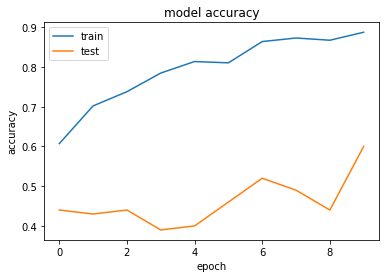

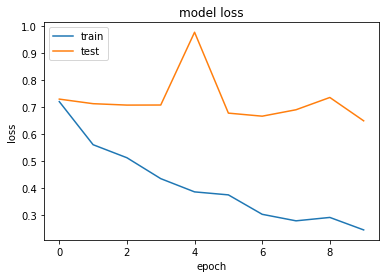

In [46]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [47]:
classes = model.predict_classes(x_test)

In [48]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[44 41]
 [50 35]]
accuracy :  0.4647058823529412
recall:  0.4117647058823529


In [49]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[44 41]
 [50 35]]
             precision    recall  f1-score   support

          0       0.47      0.52      0.49        85
          1       0.46      0.41      0.43        85

avg / total       0.46      0.46      0.46       170



### 誤分類した画像

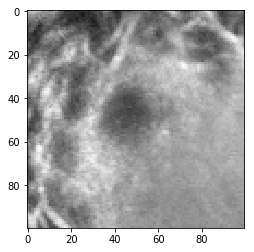

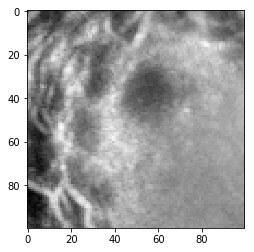

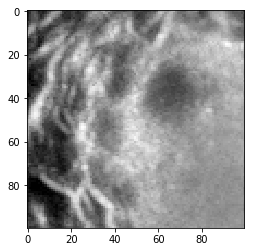

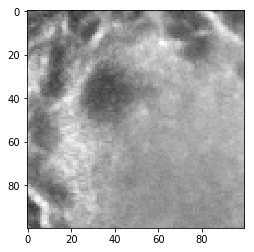

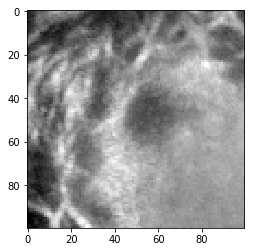

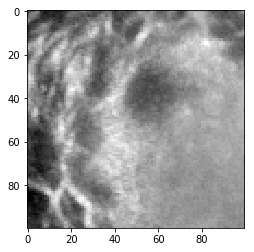

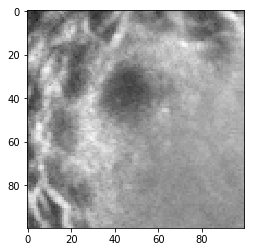

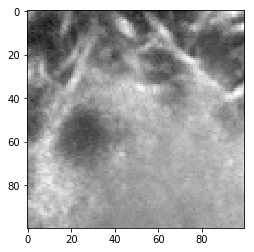

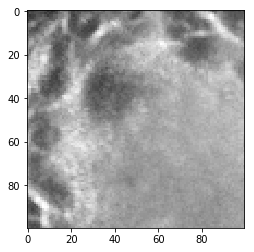

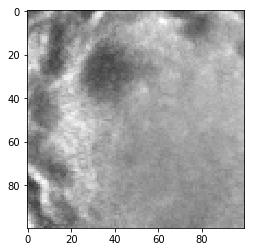

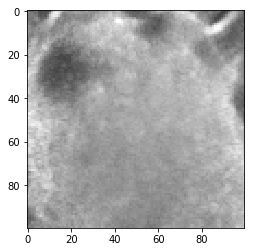

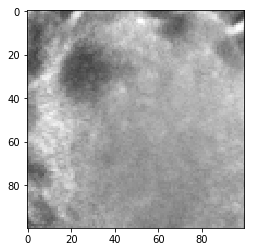

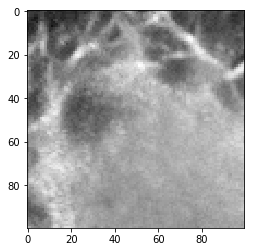

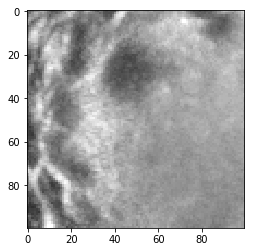

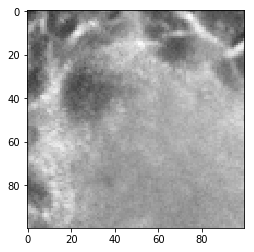

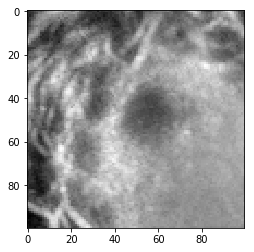

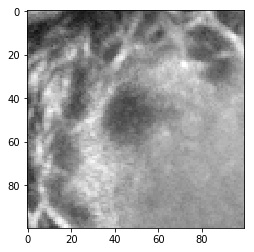

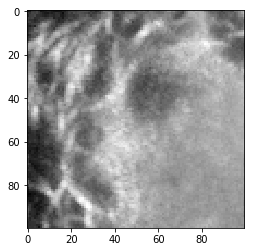

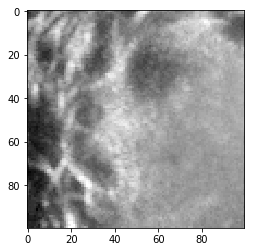

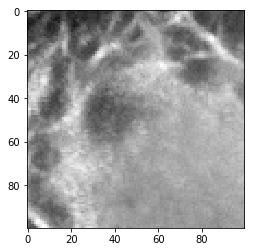

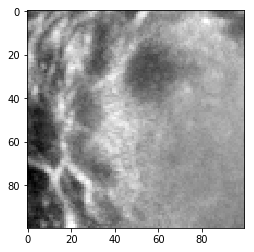

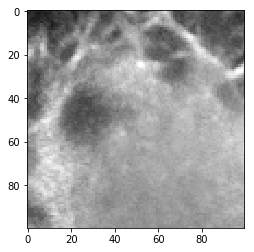

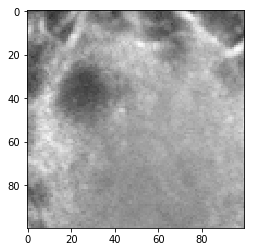

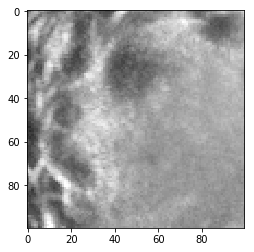

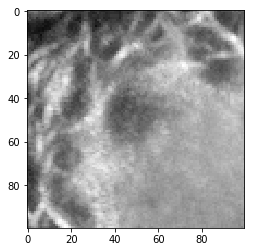

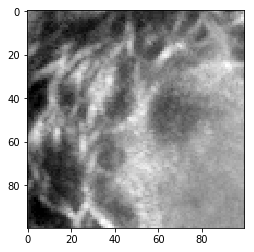

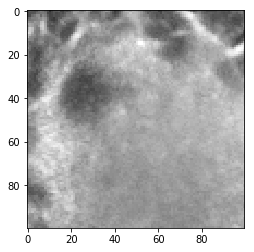

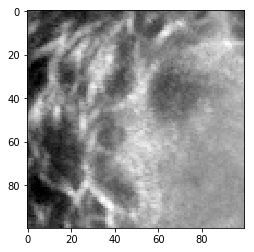

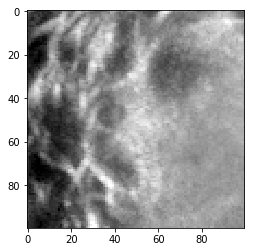

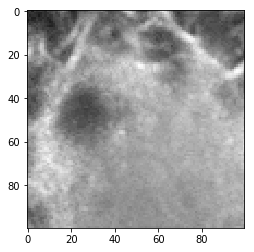

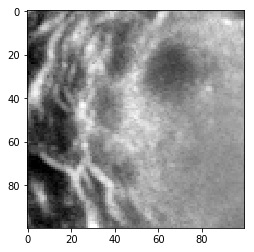

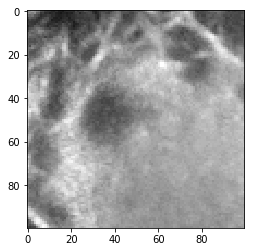

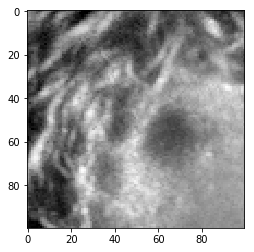

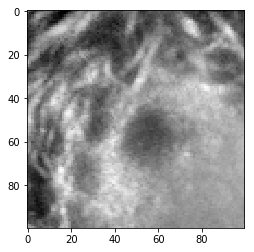

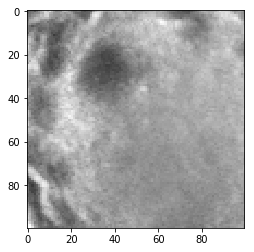

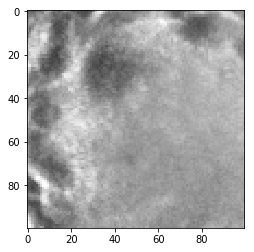

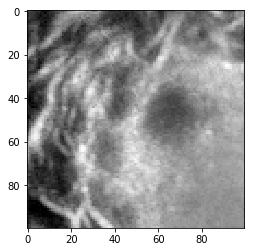

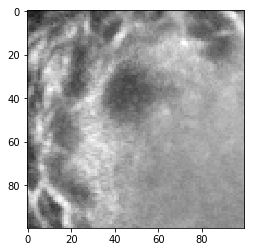

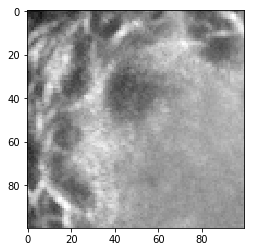

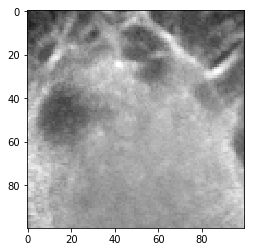

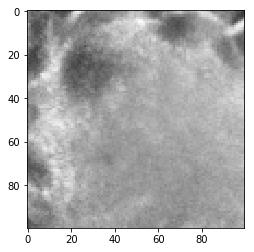

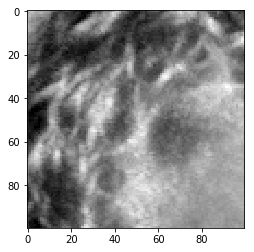

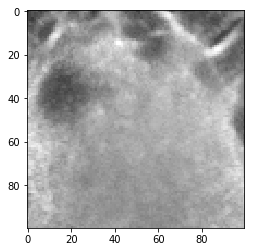

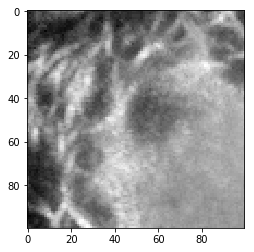

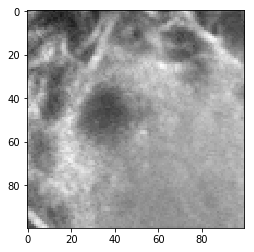

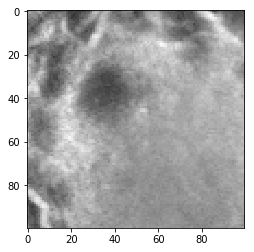

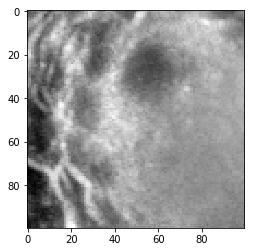

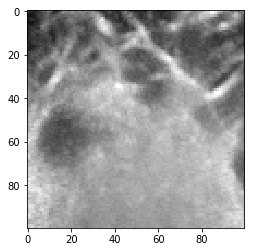

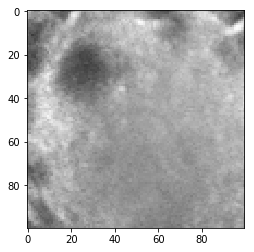

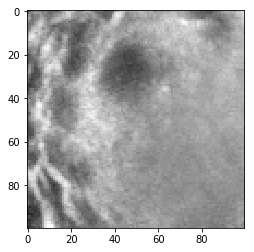

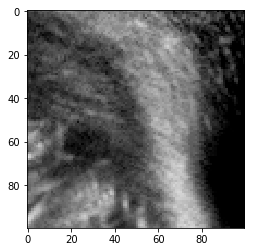

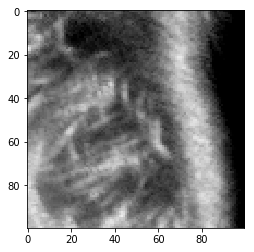

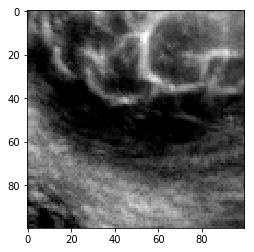

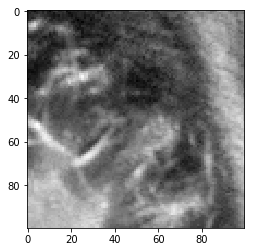

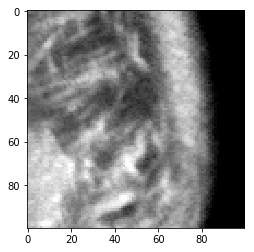

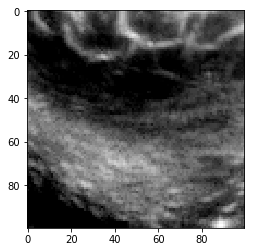

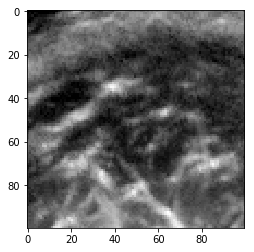

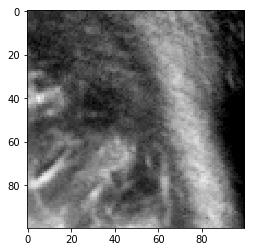

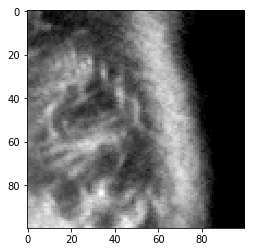

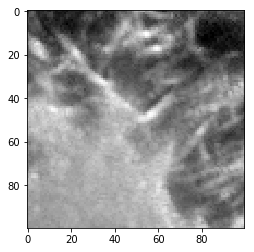

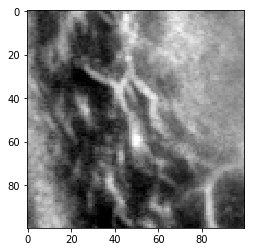

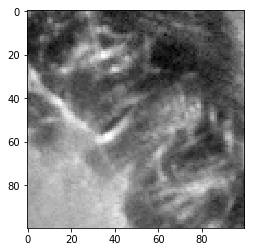

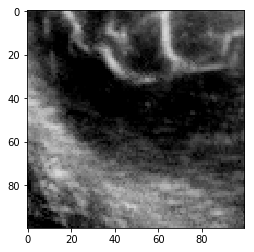

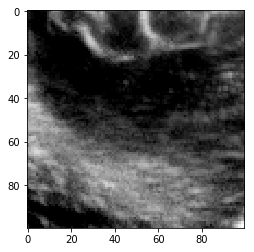

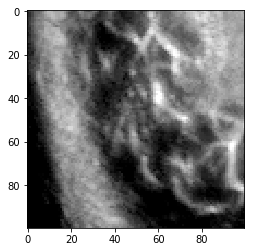

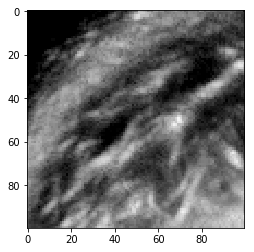

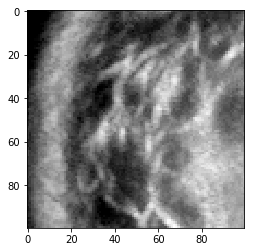

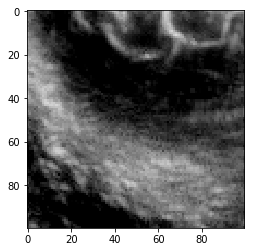

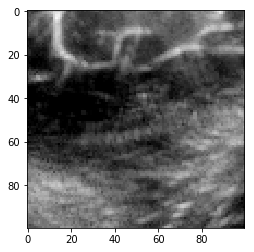

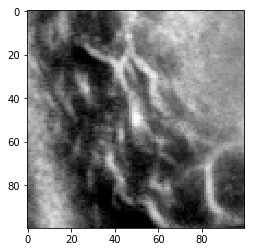

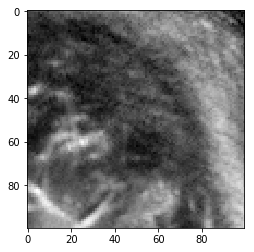

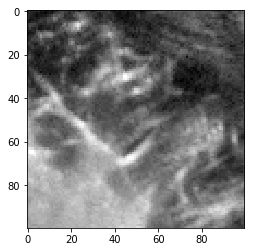

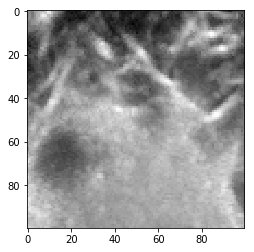

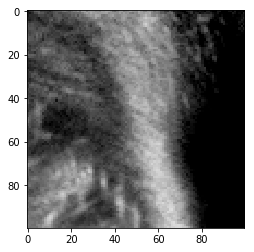

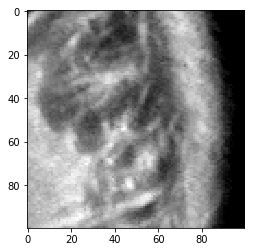

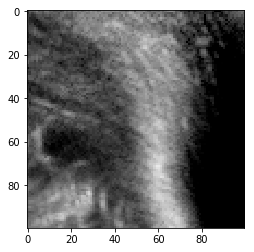

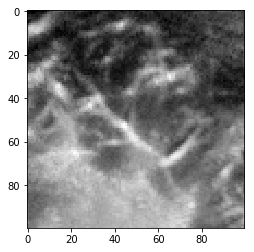

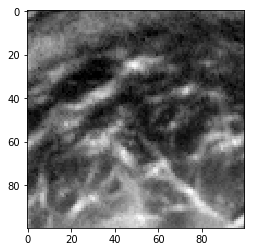

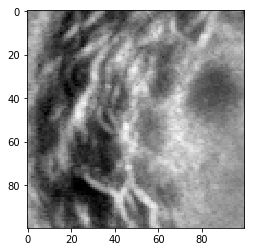

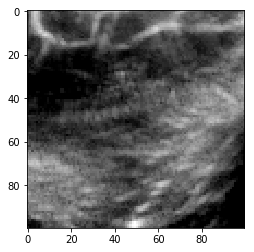

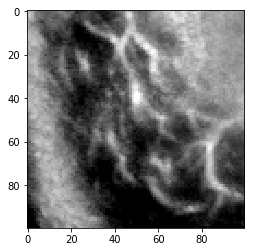

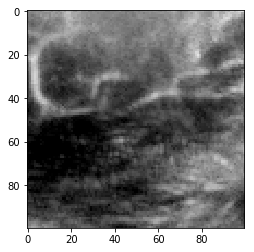

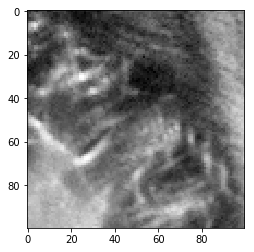

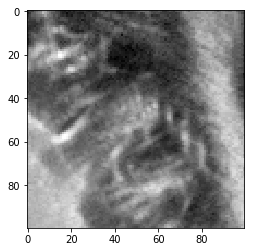

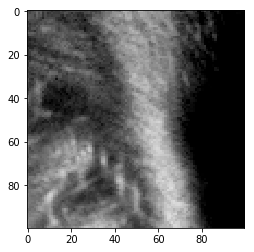

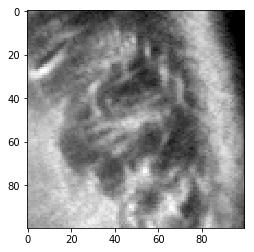

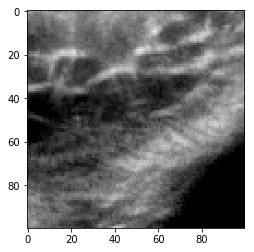

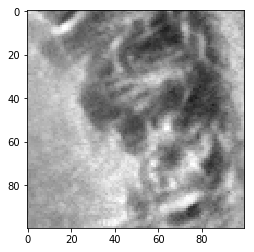

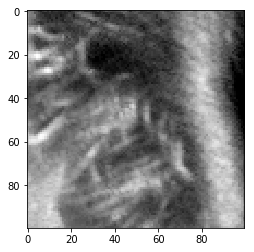

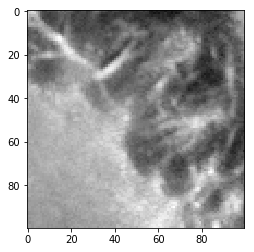

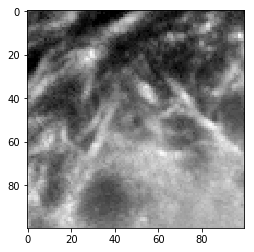

In [50]:
diff = test_seikai_label.reshape(-1,) - classes
diff_num = np.count_nonzero(diff)
diff_list = np.where(diff != 0)

for i in range(diff_num):
    plt.imshow(X_test[diff_list][i], 'gray')
    plt.show()

### validationを10%から50%, epoch:128→64

In [56]:
loss='categorical_crossentropy'
optimizer='sgd'

batch = 64
epoch = 10

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [tbcb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/10
498/498 [==============================] - 713s 1s/step - loss: 0.7994 - acc: 0.5562 - val_loss: 0.6831 - val_acc: 0.4980
Epoch 2/10
498/498 [==============================] - 687s 1s/step - loss: 0.5564 - acc: 0.6928 - val_loss: 0.6914 - val_acc: 0.4980
Epoch 3/10
498/498 [==============================] - 731s 1s/step - loss: 0.5193 - acc: 0.7349 - val_loss: 0.7077 - val_acc: 0.4859
Epoch 4/10
498/498 [==============================] - 680s 1s/step - loss: 0.4517 - acc: 0.7590 - val_loss: 0.7609 - val_acc: 0.4839
Epoch 5/10
498/498 [==============================] - 689s 1s/step - loss: 0.3729 - acc: 0.8253 - val_loss: 0.6860 - val_acc: 0.4859
Epoch 6/10
498/498 [==============================] - 702s 1s/step - loss: 0.3636 - acc: 0.8293 - val_loss: 0.6957 - val_acc: 0.5602
Epoch 7/10
498/498 [==============================] - 700s 1s/step - loss: 0.3172 - acc: 0.8835 - val_loss: 0.6870 - val_acc: 0.5341
Epoch 8/10
498/498 [===

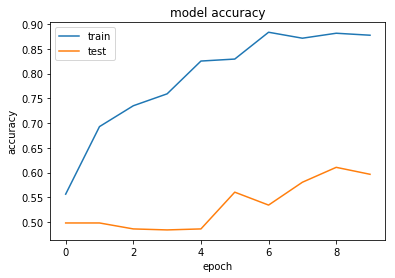

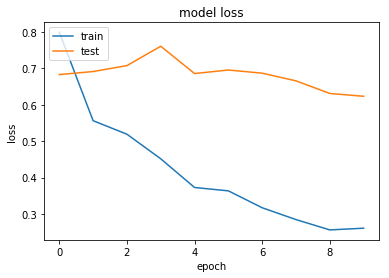

In [57]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [58]:
classes = model.predict_classes(x_test)

In [59]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[71 14]
 [79  6]]
accuracy :  0.45294117647058824
recall:  0.07058823529411765


In [60]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[71 14]
 [79  6]]
             precision    recall  f1-score   support

          0       0.47      0.84      0.60        85
          1       0.30      0.07      0.11        85

avg / total       0.39      0.45      0.36       170



- recallはまぁまぁだが、accuracyが低すぎる
- 過学習っぽい

### Normalizationをなくして, Dropoutに置き換える, validation:50%

In [61]:
n_filter = 32
n_filter2 = 64
size_filter = 20
size_filter2 = 10
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter2, size_filter2), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter2, size_filter2)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [62]:
loss='categorical_crossentropy'
optimizer='sgd'

batch = 64
epoch = 10

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
#from keras.callbacks import TensorBoard
#tbcb = TensorBoard(log_dir = './graph',
#                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [tbcb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
#score = model.evaluate(x_test, y_test, verbose=0)

#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/10
498/498 [==============================] - 661s 1s/step - loss: 0.6982 - acc: 0.4779 - val_loss: 0.6930 - val_acc: 0.5201
Epoch 2/10
498/498 [==============================] - 686s 1s/step - loss: 0.6949 - acc: 0.4900 - val_loss: 0.6928 - val_acc: 0.5321
Epoch 3/10
498/498 [==============================] - 637s 1s/step - loss: 0.6925 - acc: 0.5201 - val_loss: 0.6902 - val_acc: 0.5080
Epoch 4/10
498/498 [==============================] - 696s 1s/step - loss: 0.6906 - acc: 0.5261 - val_loss: 0.6892 - val_acc: 0.5040
Epoch 5/10
498/498 [==============================] - 676s 1s/step - loss: 0.6882 - acc: 0.5341 - val_loss: 0.6901 - val_acc: 0.5602
Epoch 6/10
498/498 [==============================] - 646s 1s/step - loss: 0.6965 - acc: 0.5120 - val_loss: 0.6908 - val_acc: 0.5964
Epoch 7/10
498/498 [==============================] - 677s 1s/step - loss: 0.6924 - acc: 0.4940 - val_loss: 0.6880 - val_acc: 0.5422
Epoch 8/10
498/498 [===

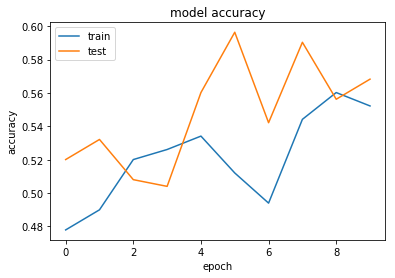

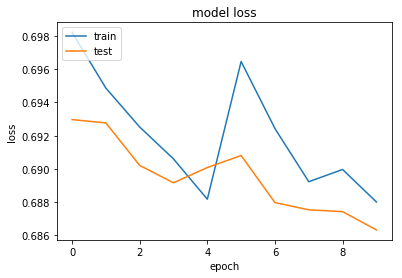

In [63]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
classes = model.predict_classes(x_test)

In [72]:
print(Counter(Y_test))
print(Counter(classes))

Counter({0: 85, 1: 85})
Counter({1: 151, 0: 19})


In [66]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[19 66]
 [ 0 85]]
accuracy :  0.611764705882353
recall:  1.0


In [67]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[19 66]
 [ 0 85]]
             precision    recall  f1-score   support

          0       1.00      0.22      0.37        85
          1       0.56      1.00      0.72        85

avg / total       0.78      0.61      0.54       170



- accuracyやlossの挙動はイマイチなように見えるがaccuracyとrecallはいい感じ？

### Batch Normalization そのものが効いていない可能性があるので, BatchNormalizationもDropoutもなくす

In [14]:
n_filter = 32
n_filter2 = 64
size_filter = 20
size_filter2 = 10
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter2, size_filter2), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter2, size_filter2)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [17]:
loss='categorical_crossentropy'
optimizer='sgd'

batch = 64
epoch = 10

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [tbcb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/10
498/498 [==============================] - 691s 1s/step - loss: 0.6943 - acc: 0.4799 - val_loss: 0.6921 - val_acc: 0.5622
Epoch 2/10
498/498 [==============================] - 608s 1s/step - loss: 0.6911 - acc: 0.5462 - val_loss: 0.6891 - val_acc: 0.5542
Epoch 3/10
498/498 [==============================] - 610s 1s/step - loss: 0.6888 - acc: 0.5542 - val_loss: 0.6872 - val_acc: 0.6185
Epoch 4/10
498/498 [==============================] - 668s 1s/step - loss: 0.6846 - acc: 0.5964 - val_loss: 0.6828 - val_acc: 0.6406
Epoch 5/10
498/498 [==============================] - 664s 1s/step - loss: 0.6835 - acc: 0.6024 - val_loss: 0.6853 - val_acc: 0.5341
Epoch 6/10
498/498 [==============================] - 660s 1s/step - loss: 0.6786 - acc: 0.5924 - val_loss: 0.6747 - val_acc: 0.6486
Epoch 7/10
498/498 [==============================] - 702s 1s/step - loss: 0.6749 - acc: 0.6004 - val_loss: 0.6678 - val_acc: 0.6365
Epoch 8/10
498/498 [===

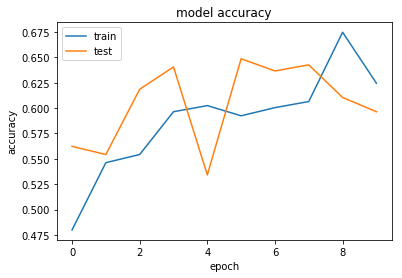

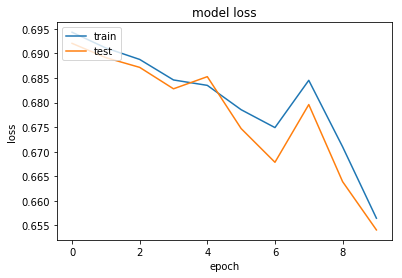

In [18]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [19]:
classes = model.predict_classes(x_test)

In [20]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[24 61]
 [ 0 85]]
accuracy :  0.6411764705882353
recall:  1.0


In [21]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[24 61]
 [ 0 85]]
             precision    recall  f1-score   support

          0       1.00      0.28      0.44        85
          1       0.58      1.00      0.74        85

avg / total       0.79      0.64      0.59       170



### Convolutionを増やす

In [22]:
n_filter = 32
n_filter2 = 64
n_filter3 = 128
size_filter = 20
size_filter2 = 10
size_filter3 = 5
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter2, size_filter2), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter2, size_filter2)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter3, (size_filter3, size_filter3), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter3, (size_filter3, size_filter3)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [23]:
print('model')
print(model.summary())

model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 32)      38432     
_________________________________________________________________
activation_7 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 81, 81, 32)        409632    
_________________________________________________________________
activation_8 (Activation)    (None, 81, 81, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 40, 40, 64)        204864    
_________________________________________________________________
activation_9 (Activation)    (None, 40, 40, 64)        0         
____

In [24]:
loss='categorical_crossentropy'
optimizer='sgd'

batch = 64
epoch = 10

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [tbcb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/10
498/498 [==============================] - 701s 1s/step - loss: 0.6929 - acc: 0.5040 - val_loss: 0.6919 - val_acc: 0.5120
Epoch 2/10
498/498 [==============================] - 710s 1s/step - loss: 0.6919 - acc: 0.5040 - val_loss: 0.6907 - val_acc: 0.5161
Epoch 3/10
498/498 [==============================] - 702s 1s/step - loss: 0.6907 - acc: 0.5040 - val_loss: 0.6894 - val_acc: 0.5201
Epoch 4/10
498/498 [==============================] - 709s 1s/step - loss: 0.6897 - acc: 0.5201 - val_loss: 0.6880 - val_acc: 0.5080
Epoch 5/10
498/498 [==============================] - 709s 1s/step - loss: 0.6889 - acc: 0.5161 - val_loss: 0.6864 - val_acc: 0.5221
Epoch 6/10
498/498 [==============================] - 705s 1s/step - loss: 0.6895 - acc: 0.5241 - val_loss: 0.6864 - val_acc: 0.5522
Epoch 7/10
498/498 [==============================] - 679s 1s/step - loss: 0.6859 - acc: 0.5582 - val_loss: 0.6832 - val_acc: 0.5703
Epoch 8/10
498/498 [===

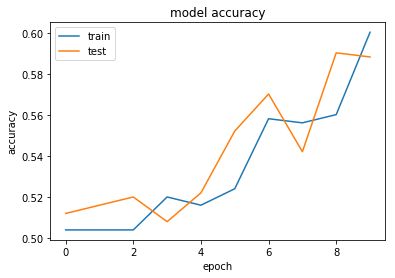

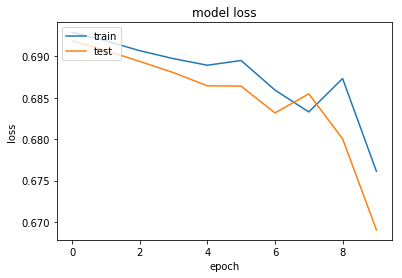

In [25]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [26]:
classes = model.predict_classes(x_test)

In [27]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[25 60]
 [ 0 85]]
accuracy :  0.6470588235294118
recall:  1.0


In [28]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[25 60]
 [ 0 85]]
             precision    recall  f1-score   support

          0       1.00      0.29      0.45        85
          1       0.59      1.00      0.74        85

avg / total       0.79      0.65      0.60       170



### フィルターサイズを小さくする

In [29]:
n_filter = 32
n_filter2 = 64
n_filter3 = 128
size_filter = 3
size_filter2 = 1
size_filter3 = 5
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter3, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter3, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [30]:
print('model')
print(model.summary())

model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
activation_15 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 49, 49, 64)        18496     
_________________________________________________________________
activation_17 (Activation)   (None, 49, 49, 64)        0         
____

In [31]:
loss='categorical_crossentropy'
optimizer='sgd'

batch = 64
epoch = 10

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [tbcb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/10
498/498 [==============================] - 59s 118ms/step - loss: 0.6935 - acc: 0.5100 - val_loss: 0.6931 - val_acc: 0.5422
Epoch 2/10
498/498 [==============================] - 70s 140ms/step - loss: 0.6932 - acc: 0.5020 - val_loss: 0.6929 - val_acc: 0.5341
Epoch 3/10
498/498 [==============================] - 75s 151ms/step - loss: 0.6930 - acc: 0.5241 - val_loss: 0.6927 - val_acc: 0.5301
Epoch 4/10
498/498 [==============================] - 69s 138ms/step - loss: 0.6928 - acc: 0.5221 - val_loss: 0.6924 - val_acc: 0.5241
Epoch 5/10
498/498 [==============================] - 66s 133ms/step - loss: 0.6926 - acc: 0.5261 - val_loss: 0.6922 - val_acc: 0.5241
Epoch 6/10
498/498 [==============================] - 62s 124ms/step - loss: 0.6923 - acc: 0.5181 - val_loss: 0.6920 - val_acc: 0.5241
Epoch 7/10
498/498 [==============================] - 61s 123ms/step - loss: 0.6921 - acc: 0.5040 - val_loss: 0.6918 - val_acc: 0.5321
Epoch 8/1

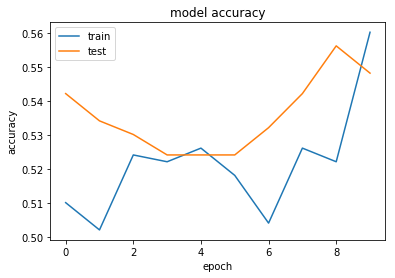

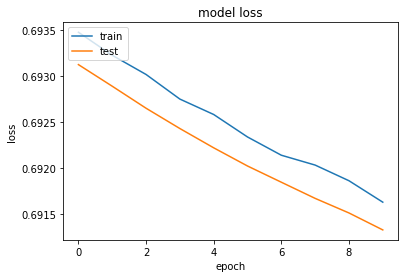

In [32]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [33]:
classes = model.predict_classes(x_test)

In [34]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[11 74]
 [ 0 85]]
accuracy :  0.5647058823529412
recall:  1.0


In [28]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[25 60]
 [ 0 85]]
             precision    recall  f1-score   support

          0       1.00      0.29      0.45        85
          1       0.59      1.00      0.74        85

avg / total       0.79      0.65      0.60       170



### フィルターサイズを小さくする epochを増やす

In [35]:
n_filter = 32
n_filter2 = 64
n_filter3 = 128
size_filter = 3
size_filter2 = 1
size_filter3 = 5
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter3, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter3, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [36]:
print('model')
print(model.summary())

model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
activation_23 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_24 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 49, 49, 64)        18496     
_________________________________________________________________
activation_25 (Activation)   (None, 49, 49, 64)        0         
____

In [37]:
loss='categorical_crossentropy'
optimizer='sgd'

batch = 64
epoch = 50

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [tbcb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/50
498/498 [==============================] - 65s 131ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6930 - val_acc: 0.5522
Epoch 2/50
498/498 [==============================] - 67s 135ms/step - loss: 0.6928 - acc: 0.5562 - val_loss: 0.6927 - val_acc: 0.5743
Epoch 3/50
498/498 [==============================] - 61s 122ms/step - loss: 0.6925 - acc: 0.5582 - val_loss: 0.6924 - val_acc: 0.5703
Epoch 4/50
498/498 [==============================] - 61s 123ms/step - loss: 0.6922 - acc: 0.5542 - val_loss: 0.6921 - val_acc: 0.5683
Epoch 5/50
498/498 [==============================] - 62s 125ms/step - loss: 0.6919 - acc: 0.5783 - val_loss: 0.6918 - val_acc: 0.5622
Epoch 6/50
498/498 [==============================] - 63s 126ms/step - loss: 0.6916 - acc: 0.5582 - val_loss: 0.6916 - val_acc: 0.5562
Epoch 7/50
498/498 [==============================] - 59s 118ms/step - loss: 0.6914 - acc: 0.5562 - val_loss: 0.6913 - val_acc: 0.5462
Epoch 8/5

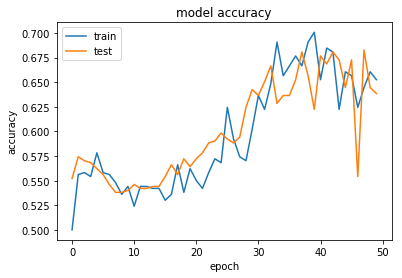

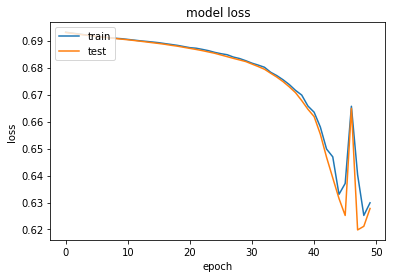

In [38]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [39]:
classes = model.predict_classes(x_test)

In [40]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[71 14]
 [72 13]]
accuracy :  0.49411764705882355
recall:  0.15294117647058825


In [41]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[71 14]
 [72 13]]
             precision    recall  f1-score   support

          0       0.50      0.84      0.62        85
          1       0.48      0.15      0.23        85

avg / total       0.49      0.49      0.43       170



- accuracyがギザギザなるのは学習率が高いから？

### optimizerをAdagradで

In [42]:
n_filter = 32
n_filter2 = 64
n_filter3 = 128
size_filter = 3
size_filter2 = 1
size_filter3 = 5
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter3, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter3, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [43]:
print('model')
print(model.summary())

model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
activation_31 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 49, 49, 64)        18496     
_________________________________________________________________
activation_33 (Activation)   (None, 49, 49, 64)        0         
____

In [46]:

loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
optimizer='Adadelta'

batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [tbcb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/20
498/498 [==============================] - 64s 129ms/step - loss: 0.6928 - acc: 0.5241 - val_loss: 0.6867 - val_acc: 0.5080
Epoch 2/20
498/498 [==============================] - 66s 133ms/step - loss: 0.6821 - acc: 0.5281 - val_loss: 0.7582 - val_acc: 0.5020
Epoch 3/20
498/498 [==============================] - 65s 131ms/step - loss: 0.7317 - acc: 0.6386 - val_loss: 0.6725 - val_acc: 0.7169
Epoch 4/20
498/498 [==============================] - 66s 132ms/step - loss: 0.6604 - acc: 0.6908 - val_loss: 0.6764 - val_acc: 0.4980
Epoch 5/20
498/498 [==============================] - 63s 127ms/step - loss: 0.6358 - acc: 0.6546 - val_loss: 0.5552 - val_acc: 0.7410
Epoch 6/20
498/498 [==============================] - 69s 139ms/step - loss: 0.5611 - acc: 0.7169 - val_loss: 0.5013 - val_acc: 0.7470
Epoch 7/20
498/498 [==============================] - 64s 128ms/step - loss: 0.5586 - acc: 0.6988 - val_loss: 0.5265 - val_acc: 0.7490
Epoch 8/2

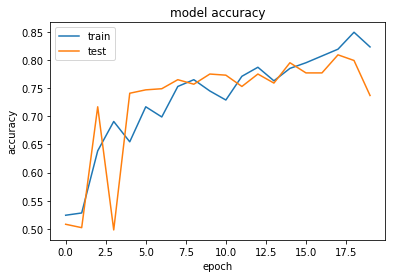

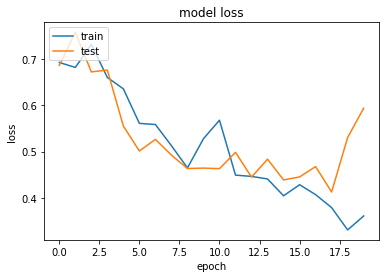

In [47]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [48]:
classes = model.predict_classes(x_test)

In [49]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[67 18]
 [28 57]]
accuracy :  0.7294117647058823
recall:  0.6705882352941176


In [41]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[71 14]
 [72 13]]
             precision    recall  f1-score   support

          0       0.50      0.84      0.62        85
          1       0.48      0.15      0.23        85

avg / total       0.49      0.49      0.43       170



### optimizerをAdamで

In [50]:

loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
optimizer='Adam'

batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [tbcb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/20
498/498 [==============================] - 58s 117ms/step - loss: 0.8023 - acc: 0.7329 - val_loss: 0.5254 - val_acc: 0.7088
Epoch 2/20
498/498 [==============================] - 56s 113ms/step - loss: 0.5205 - acc: 0.7329 - val_loss: 0.4807 - val_acc: 0.7510
Epoch 3/20
498/498 [==============================] - 58s 116ms/step - loss: 0.4758 - acc: 0.7651 - val_loss: 0.4626 - val_acc: 0.7711
Epoch 4/20
498/498 [==============================] - 61s 122ms/step - loss: 0.4539 - acc: 0.7871 - val_loss: 0.4604 - val_acc: 0.7771
Epoch 5/20
498/498 [==============================] - 82s 164ms/step - loss: 0.4473 - acc: 0.7932 - val_loss: 0.4664 - val_acc: 0.7831
Epoch 6/20
498/498 [==============================] - 64s 129ms/step - loss: 0.4364 - acc: 0.7932 - val_loss: 0.4518 - val_acc: 0.7871
Epoch 7/20
498/498 [==============================] - 60s 121ms/step - loss: 0.4168 - acc: 0.7952 - val_loss: 0.4793 - val_acc: 0.7892
Epoch 8/2

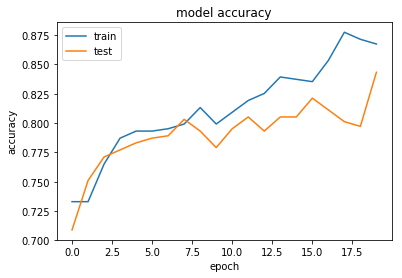

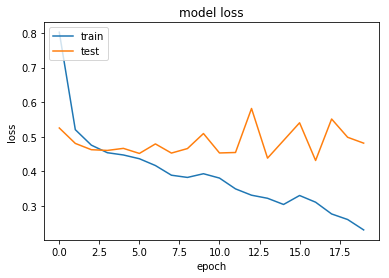

In [51]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [52]:
classes = model.predict_classes(x_test)

In [53]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[64 21]
 [48 37]]
accuracy :  0.5941176470588235
recall:  0.43529411764705883


In [54]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[64 21]
 [48 37]]
             precision    recall  f1-score   support

          0       0.57      0.75      0.65        85
          1       0.64      0.44      0.52        85

avg / total       0.60      0.59      0.58       170



### 最後のActivationをsoftmax

In [62]:
n_filter = 32
n_filter2 = 64
n_filter3 = 128
size_filter = 3
size_filter2 = 1
size_filter3 = 5
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter3, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter3, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [57]:

loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
optimizer='Adam'

batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
#from keras.callbacks import TensorBoard
#tbcb = TensorBoard(log_dir = './graph',
#                histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [es_cb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/20
498/498 [==============================] - 60s 120ms/step - loss: 0.8051 - acc: 0.5000 - val_loss: 0.6687 - val_acc: 0.4980
Epoch 2/20
498/498 [==============================] - 58s 116ms/step - loss: 0.6308 - acc: 0.5663 - val_loss: 0.5772 - val_acc: 0.7329
Epoch 3/20
498/498 [==============================] - 60s 120ms/step - loss: 0.5800 - acc: 0.7108 - val_loss: 0.5522 - val_acc: 0.7590
Epoch 4/20
498/498 [==============================] - 62s 125ms/step - loss: 0.5412 - acc: 0.7390 - val_loss: 0.5107 - val_acc: 0.7631
Epoch 5/20
498/498 [==============================] - 59s 118ms/step - loss: 0.5007 - acc: 0.7731 - val_loss: 0.4646 - val_acc: 0.7791
Epoch 6/20
498/498 [==============================] - 57s 115ms/step - loss: 0.4664 - acc: 0.7671 - val_loss: 0.4515 - val_acc: 0.7932
Epoch 7/20
498/498 [==============================] - 57s 114ms/step - loss: 0.4489 - acc: 0.7851 - val_loss: 0.4372 - val_acc: 0.8032
Epoch 8/2

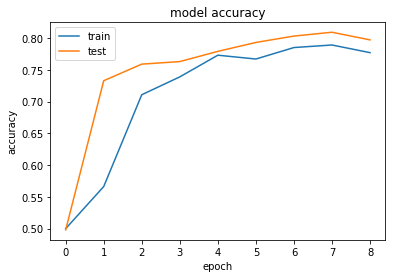

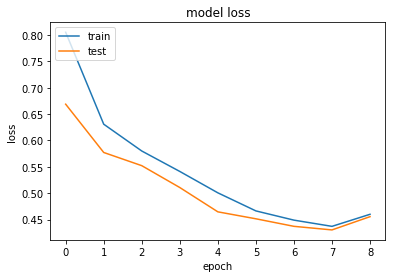

In [58]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [59]:
classes = model.predict_classes(x_test)

In [60]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[39 46]
 [ 5 80]]
accuracy :  0.7
recall:  0.9411764705882353


In [61]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[39 46]
 [ 5 80]]
             precision    recall  f1-score   support

          0       0.89      0.46      0.60        85
          1       0.63      0.94      0.76        85

avg / total       0.76      0.70      0.68       170



### optimizerをAdamで（early_stopping）

In [63]:

loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
optimizer='Adam'

batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
#from keras.callbacks import TensorBoard
#tbcb = TensorBoard(log_dir = './graph',
#                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [es_cb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/20
498/498 [==============================] - 63s 127ms/step - loss: 0.8689 - acc: 0.4960 - val_loss: 0.6888 - val_acc: 0.5703
Epoch 2/20
498/498 [==============================] - 58s 116ms/step - loss: 0.6781 - acc: 0.5843 - val_loss: 0.5828 - val_acc: 0.7269
Epoch 3/20
498/498 [==============================] - 59s 118ms/step - loss: 0.7114 - acc: 0.6446 - val_loss: 0.5631 - val_acc: 0.7249
Epoch 4/20
498/498 [==============================] - 59s 118ms/step - loss: 0.5639 - acc: 0.7129 - val_loss: 0.4987 - val_acc: 0.7651
Epoch 5/20
498/498 [==============================] - 61s 122ms/step - loss: 0.5273 - acc: 0.7430 - val_loss: 0.5273 - val_acc: 0.7430
Test loss: 0.5420075626934275
Test accuracy: 0.7058823536424076


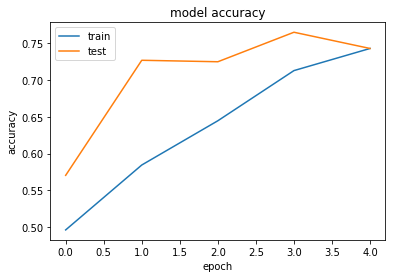

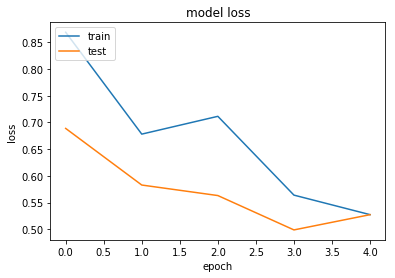

In [64]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [65]:
classes = model.predict_classes(x_test)

In [66]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[35 50]
 [ 0 85]]
accuracy :  0.7058823529411765
recall:  1.0


In [54]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[64 21]
 [48 37]]
             precision    recall  f1-score   support

          0       0.57      0.75      0.65        85
          1       0.64      0.44      0.52        85

avg / total       0.60      0.59      0.58       170



### Adam

In [14]:
n_filter = 32
n_filter2 = 64
n_filter3 = 128
size_filter = 3
size_filter2 = 1
size_filter3 = 5
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter3, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter3, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [44]:
#from yellowfin import YFOptimizer
#from keras.optimizers import TFOptimizer
#from keras.optimizers import Adam

In [15]:
loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
#opt = TFOptimizer(YFOptimizer())
optimizer = "Adam"
batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [es_cb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/20
498/498 [==============================] - 67s 134ms/step - loss: 0.7024 - acc: 0.4859 - val_loss: 1.0026 - val_acc: 0.4980
Epoch 2/20
498/498 [==============================] - 59s 119ms/step - loss: 0.6942 - acc: 0.6325 - val_loss: 0.6681 - val_acc: 0.5301
Epoch 3/20
498/498 [==============================] - 58s 116ms/step - loss: 0.6145 - acc: 0.6707 - val_loss: 0.5870 - val_acc: 0.6867
Epoch 4/20
498/498 [==============================] - 57s 115ms/step - loss: 0.5254 - acc: 0.7430 - val_loss: 0.5177 - val_acc: 0.7550
Epoch 5/20
498/498 [==============================] - 57s 115ms/step - loss: 0.4816 - acc: 0.7691 - val_loss: 0.5024 - val_acc: 0.7610
Epoch 6/20
498/498 [==============================] - 57s 115ms/step - loss: 0.4926 - acc: 0.7631 - val_loss: 0.4792 - val_acc: 0.7550
Epoch 7/20
498/498 [==============================] - 61s 122ms/step - loss: 0.4688 - acc: 0.7651 - val_loss: 0.4566 - val_acc: 0.7851
Epoch 8/2

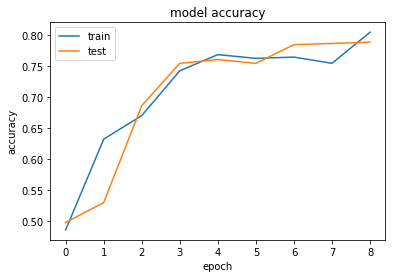

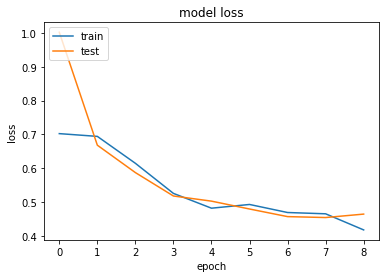

In [16]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [17]:
classes = model.predict_classes(x_test)

In [18]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[47 38]
 [ 2 83]]
accuracy :  0.7647058823529411
recall:  0.9764705882352941


In [19]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[47 38]
 [ 2 83]]
             precision    recall  f1-score   support

          0       0.96      0.55      0.70        85
          1       0.69      0.98      0.81        85

avg / total       0.82      0.76      0.75       170



### BatchNormalizationを各Convolutionの後で行う

In [20]:
n_filter = 32
n_filter2 = 64
n_filter3 = 128
size_filter = 3
size_filter2 = 1
size_filter3 = 5
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()


model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter3, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter3, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [21]:
#from yellowfin import YFOptimizer
#from keras.optimizers import TFOptimizer
#from keras.optimizers import Adam

In [22]:
loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
#opt = TFOptimizer(YFOptimizer())
optimizer = "Adam"
batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [es_cb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/20
498/498 [==============================] - 128s 257ms/step - loss: 1.1962 - acc: 0.5783 - val_loss: 1.9416 - val_acc: 0.5020
Epoch 2/20
498/498 [==============================] - 119s 238ms/step - loss: 0.7184 - acc: 0.5100 - val_loss: 0.6933 - val_acc: 0.5964
Epoch 3/20
498/498 [==============================] - 121s 242ms/step - loss: 0.9565 - acc: 0.5502 - val_loss: 0.6931 - val_acc: 0.4980
Epoch 4/20
498/498 [==============================] - 130s 260ms/step - loss: 0.8004 - acc: 0.5040 - val_loss: 0.6931 - val_acc: 0.4980
Test loss: 0.6931471824645996
Test accuracy: 0.5


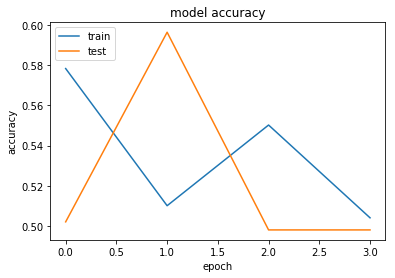

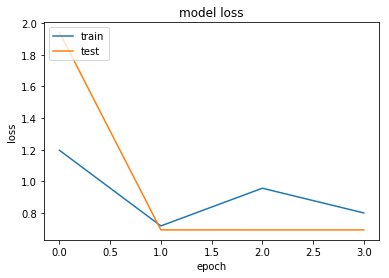

In [23]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [24]:
classes = model.predict_classes(x_test)

In [25]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[85  0]
 [85  0]]
accuracy :  0.5
recall:  0.0


In [19]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[47 38]
 [ 2 83]]
             precision    recall  f1-score   support

          0       0.96      0.55      0.70        85
          1       0.69      0.98      0.81        85

avg / total       0.82      0.76      0.75       170



In [42]:
n_filter = 32
n_filter2 = 64
n_filter3 = 128
size_filter = 3
size_filter2 = 1
size_filter3 = 5
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter3, (size_filter, size_filter), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter3, (size_filter, size_filter)))
model.add(Activation('relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))

model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

In [53]:
print('model')
print(model.summary())

model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 96, 96, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 96, 96, 32)   9248        conv2d_116[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 48, 48, 32)   0           conv2d_117[0][0]                 
__________________________________________________________________________________________________
conv

In [49]:
img_rows = 96
img_cols = 96
smooth = 1.

### U-Net

In [50]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [51]:
inputs = Input((img_rows, img_cols, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
model = Model(inputs=[inputs], outputs=[conv10])


NameError: name 'Adam' is not defined

In [ ]:
loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
#opt = TFOptimizer(YFOptimizer())
optimizer = "Adam"
batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [es_cb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [63]:

loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
optimizer='Adam'

batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
#from keras.callbacks import TensorBoard
#tbcb = TensorBoard(log_dir = './graph',
#                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [es_cb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/20
498/498 [==============================] - 63s 127ms/step - loss: 0.8689 - acc: 0.4960 - val_loss: 0.6888 - val_acc: 0.5703
Epoch 2/20
498/498 [==============================] - 58s 116ms/step - loss: 0.6781 - acc: 0.5843 - val_loss: 0.5828 - val_acc: 0.7269
Epoch 3/20
498/498 [==============================] - 59s 118ms/step - loss: 0.7114 - acc: 0.6446 - val_loss: 0.5631 - val_acc: 0.7249
Epoch 4/20
498/498 [==============================] - 59s 118ms/step - loss: 0.5639 - acc: 0.7129 - val_loss: 0.4987 - val_acc: 0.7651
Epoch 5/20
498/498 [==============================] - 61s 122ms/step - loss: 0.5273 - acc: 0.7430 - val_loss: 0.5273 - val_acc: 0.7430
Test loss: 0.5420075626934275
Test accuracy: 0.7058823536424076


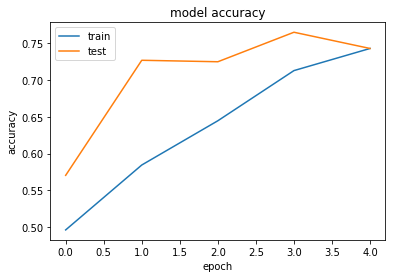

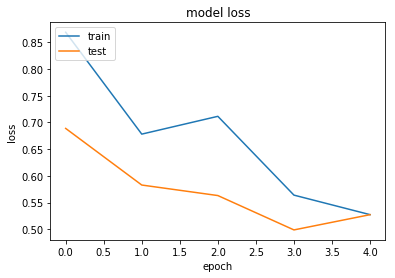

In [64]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 正答率

In [65]:
classes = model.predict_classes(x_test)

In [66]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[35 50]
 [ 0 85]]
accuracy :  0.7058823529411765
recall:  1.0


In [54]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[64 21]
 [48 37]]
             precision    recall  f1-score   support

          0       0.57      0.75      0.65        85
          1       0.64      0.44      0.52        85

avg / total       0.60      0.59      0.58       170



In [65]:
n_filter = 32
n_filter2 = 64
size_filter = 3
size_filter2 = 10
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(BatchNormalization(momentum = 0.9, axis=-1, input_shape=X_train.shape[1:]))
model.add(Conv2D(32, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
model.add(BatchNormalization(momentum = 0.9, axis=-1))
model.add(Conv2D(32, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(BatchNormalization(momentum = 0.9, axis=-1))
model.add(Conv2D(64, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
model.add(BatchNormalization(momentum = 0.9, axis=-1))
model.add(Conv2D(64, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(BatchNormalization(momentum = 0.9, axis=-1))
model.add(Conv2D(128, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
model.add(BatchNormalization(momentum = 0.9, axis=-1))
model.add(Conv2D(128, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(BatchNormalization(momentum = 0.9, axis=-1))
model.add(Conv2D(256, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
model.add(BatchNormalization(momentum = 0.9, axis=-1))
model.add(Conv2D(256, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

#model.add(BatchNormalization(momentum = 0.9, axis=-1))
#model.add(Conv2D(256, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
#model.add(BatchNormalization(momentum = 0.9, axis=-1))
#model.add(Conv2D(256, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

#model.add(BatchNormalization(momentum = 0.9, axis=-1))
#model.add(Conv2D(512, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
#model.add(BatchNormalization(momentum = 0.9, axis=-1))
#model.add(Conv2D(512, kernel_size = 3, strides = 1, padding='same', activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

#model.add(BatchNormalization(momentum = 0.9, axis=-1))
#model.add(Flatten())

#model.add(BatchNormalization(momentum = 0.9, axis=-1))
#model.add(Dense(1024, activation = 'relu'))
#model.add(BatchNormalization(momentum = 0.9, axis=-1))
#model.add(Dense(512), activation = 'relu')

#model.add(BatchNormalization(momentum = 0.9, axis=-1))
#model.add(Dense(2), activation = 'softmax')

model.add(BatchNormalization(momentum = 0.9, axis=-1))
model.add(Conv2D(1024, kernel_size = 3, strides = 1, padding='valid', activation = 'relu'))
model.add(BatchNormalization(momentum = 0.9, axis=-1))
model.add(Conv2D(512, kernel_size = 1, strides = 1, padding='valid', activation = 'relu'))

#model.add(BatchNormalization(momentum = 0.9, axis=-1))
#model.add(Conv2D(512, kernel_size = 1, strides = 1, padding='valid', activation = 'relu'))


#model.add(BatchNormalization(momentum = 0.9, axis=-1))
#model.add(Conv2D(2, kernel_size = 1, strides = 1, padding='valid', activation = 'relu'))

#model.add(Flatten())
#model.add(Dense(n_hidden))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(n_label))       # クラスは2個
#model.add(Activation('sigmoid'))

In [66]:
print('model')
print(model.summary())

model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_167 (Bat (None, 100, 100, 3)       12        
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization_168 (Bat (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_169 (Bat (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 50, 50, 64)        18496     
____

### フィルターの可視化

In [51]:
# list of the layers
lays = model.layers
for i, l in enumerate(lays):
    print(i+1, l)
w1 = model.layers[0].get_weights()[0]
b1 = model.layers[0].get_weights()[1]

print(w1.shape, b1.shape)
print(model.layers[0].get_weights()[0].shape)

1 <keras.layers.convolutional.Conv2D object at 0x1a46f87a20>
2 <keras.layers.core.Activation object at 0x1a46f87b70>
3 <keras.layers.convolutional.Conv2D object at 0x1a288e4400>
4 <keras.layers.core.Activation object at 0x1a2869cdd8>
5 <keras.layers.normalization.BatchNormalization object at 0x1a28503b00>
6 <keras.layers.pooling.MaxPooling2D object at 0x1a28503c88>
7 <keras.layers.convolutional.Conv2D object at 0x1a2ba64b00>
8 <keras.layers.core.Activation object at 0x1a3fff3f98>
9 <keras.layers.normalization.BatchNormalization object at 0x1a295ad470>
10 <keras.layers.convolutional.Conv2D object at 0x1a295ade10>
11 <keras.layers.core.Activation object at 0x1a3fdb35c0>
12 <keras.layers.normalization.BatchNormalization object at 0x1a33d88908>
13 <keras.layers.pooling.MaxPooling2D object at 0x1a33d5aba8>
14 <keras.layers.core.Flatten object at 0x1a295d4b70>
15 <keras.layers.core.Dense object at 0x1a28b9d6a0>
16 <keras.layers.core.Activation object at 0x1a28c206a0>
17 <keras.layers.core.Dr

Layer Name: conv2d_13


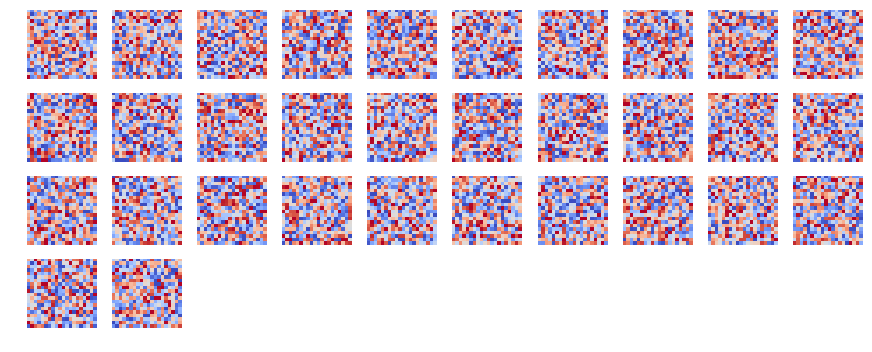

In [52]:
layer_num = 0  # 0=畳み込み1層目

from keras.models import model_from_json
from pylab import rcParams

rcParams['figure.figsize'] = 15,15

model = None
with open('model.json') as f:
    model = model_from_json(f.read())

model.load_weights('weights.hdf5')


print('Layer Name: {}'.format(model.layers[layer_num].get_config()['name']))

W = model.layers[layer_num].get_weights()[0]
W = W.transpose(3, 2, 0, 1) # 配列を転置する
nb_filter, nb_channel, nb_row, nb_col = W.shape

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.figure()
for i in range(nb_filter):
    im = W[i, 0]
    # 重みを0-255のスケールに変換する
    scaler = MinMaxScaler(feature_range=(0, 255))
    im = scaler.fit_transform(im)
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(im, cmap='coolwarm', interpolation='nearest')
plt.show()

Layer Name: conv2d_14


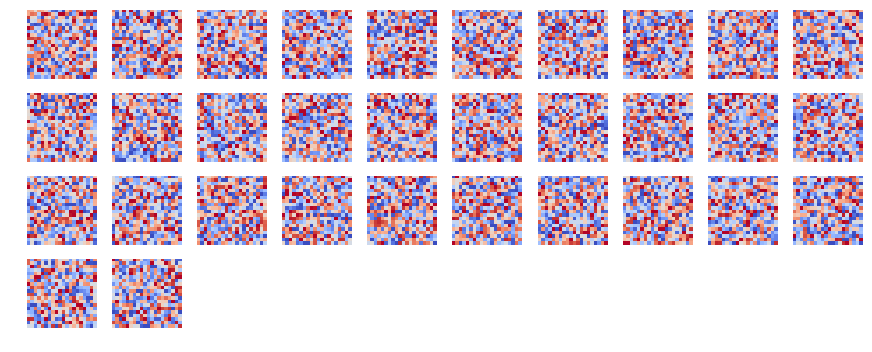

In [53]:
layer_num = 2  # 0=畳み込み1層目

from keras.models import model_from_json
from pylab import rcParams

rcParams['figure.figsize'] = 15,15

model = None
with open('model.json') as f:
    model = model_from_json(f.read())

model.load_weights('weights.hdf5')


print('Layer Name: {}'.format(model.layers[layer_num].get_config()['name']))

W = model.layers[layer_num].get_weights()[0]
W = W.transpose(3, 2, 0, 1) # 配列を転置する
nb_filter, nb_channel, nb_row, nb_col = W.shape

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.figure()
for i in range(nb_filter):
    im = W[i, 0]
    # 重みを0-255のスケールに変換する
    scaler = MinMaxScaler(feature_range=(0, 255))
    im = scaler.fit_transform(im)
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(im, cmap='coolwarm', interpolation='nearest')
plt.show()

Layer Name: conv2d_15


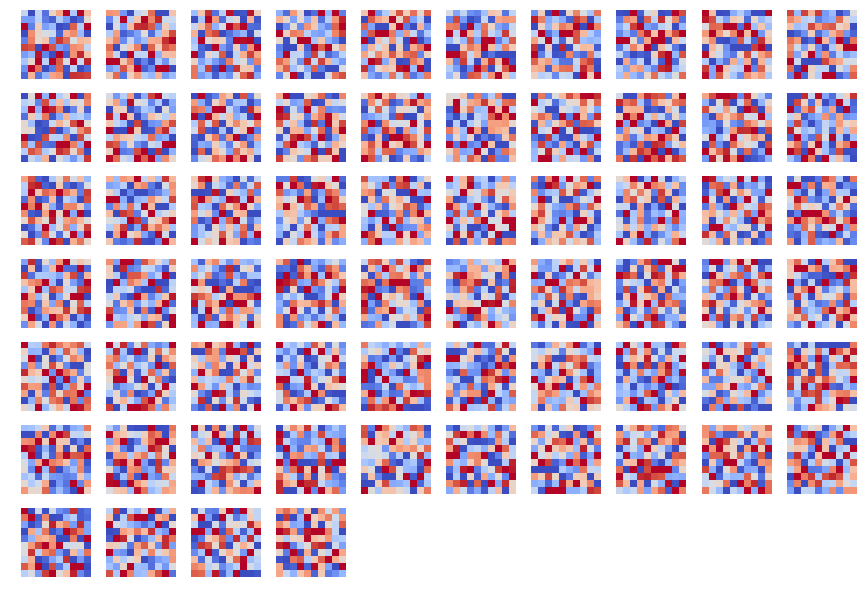

In [54]:
layer_num = 6  # 0=畳み込み1層目

from keras.models import model_from_json
from pylab import rcParams

rcParams['figure.figsize'] = 15,15

model = None
with open('model.json') as f:
    model = model_from_json(f.read())

model.load_weights('weights.hdf5')


print('Layer Name: {}'.format(model.layers[layer_num].get_config()['name']))

W = model.layers[layer_num].get_weights()[0]
W = W.transpose(3, 2, 0, 1) # 配列を転置する
nb_filter, nb_channel, nb_row, nb_col = W.shape

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.figure()
for i in range(nb_filter):
    im = W[i, 0]
    # 重みを0-255のスケールに変換する
    scaler = MinMaxScaler(feature_range=(0, 255))
    im = scaler.fit_transform(im)
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(im, cmap='coolwarm', interpolation='nearest')
plt.show()

Layer Name: conv2d_16


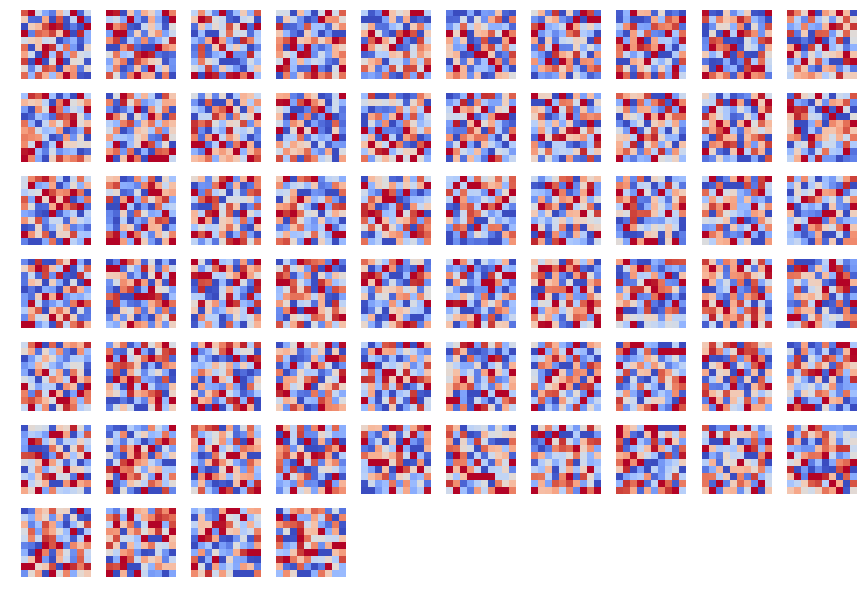

In [55]:
layer_num = 9  # 0=畳み込み1層目

from keras.models import model_from_json
from pylab import rcParams

rcParams['figure.figsize'] = 15,15

model = None
with open('model.json') as f:
    model = model_from_json(f.read())

model.load_weights('weights.hdf5')


print('Layer Name: {}'.format(model.layers[layer_num].get_config()['name']))

W = model.layers[layer_num].get_weights()[0]
W = W.transpose(3, 2, 0, 1) # 配列を転置する
nb_filter, nb_channel, nb_row, nb_col = W.shape

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.figure()
for i in range(nb_filter):
    im = W[i, 0]
    # 重みを0-255のスケールに変換する
    scaler = MinMaxScaler(feature_range=(0, 255))
    im = scaler.fit_transform(im)
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(im, cmap='coolwarm', interpolation='nearest')
plt.show()

色はfilterの大きさを表し、赤が大きく青が小さい。

### 中間層の可視化

In [56]:
# 正しく評価した/していないimageを取得する関数
def get_imgs(num, flg_correct=True):
    if flg_correct:
        mask = ((Y_test == num) & (y_pred == Y_test))
    else:
        mask = ((Y_test == num) & (y_pred != Y_test))
    return x_test[mask], y_pred[mask]

In [57]:
# 2層目まで（convolution -> relu)を取得
layers = model.layers.copy()[:2]  

# 新しいmodel(model2)にlayerを入れる
model2 = Sequential()
for layer in layers:
    model2.add(layer)
model2.compile(loss='categorical_crossentropy', optimizer='RMSprop')  # compileするだけ (loss, optimizerは使わない)

↑のloss と optimizerについて

In [58]:
num = 1  # 表示する数字
m = 2  # 表示する数字の枚数
rcParams['figure.figsize'] = 15,15

#filterの表示
W = model2.layers[layer_num].get_weights()[0]
W = W.transpose(3, 2, 0, 1) # 配列を転置する
nb_filter, nb_channel, nb_row, nb_col = W.shape

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.figure()
for i in range(nb_filter):
    im = W[i, 0]
    # 重みを0-255のスケールに変換する
    scaler = MinMaxScaler(feature_range=(0, 255))
    im = scaler.fit_transform(im)
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(im, cmap='coolwarm', interpolation='nearest')

#合っているイメージと間違っているイメージを取得
xs_correct, nums_correct = get_imgs(num, flg_correct=True)
xs_wrong, nums_wrong = get_imgs(num, flg_correct=False)

# m枚ずつ抜き出しmerge
xs = np.concatenate([xs_correct[:m], xs_wrong[:m]])
ys = np.concatenate([nums_correct[:m], nums_wrong[:m]])
# filterd imagesを取得
imgs_f = model2.predict(xs)

# 表示 -------------------------------------------
for x, num_pred, img_f in zip(xs, ys, imgs_f):
    # 元イメージ
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(x[0], cmap='gray',interpolation='nearest')
    plt.text(0, -1, num, fontsize=14, color='blue')
    plt.text(2, -1, num_pred, fontsize=14, color='red')
    # filter後のイメージ
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(img_f):
        plt.subplot(10, 10, i + 1)
        plt.axis('off')
        plt.imshow(img, cmap='gray',interpolation='nearest')
#    break

IndexError: list index out of range

In [59]:
#rcParams['figure.figsize'] = 15,15
test_wrong = [im for im in zip(x_test, y_pred, Y_test)
              if im[1] != im[2]]
print(len(test_wrong))

#plt.figure(figsize=(15, 15))
for ind, val in enumerate(test_wrong):
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.subplot(10, 10, ind + 1)
    im = 1 - val[0][0]
    plt.axis("off")
    plt.imshow(im, cmap='gray')
#    plt.text(8, 0, val[1], fontsize=14, color='red')
#    plt.text(0, 0, val[2], fontsize=14, color='blue')
#     break

NameError: name 'y_pred' is not defined

In [196]:
im.shape

(100, 3)

In [215]:
xs_correct[:2].shape

(1, 100, 100, 3)

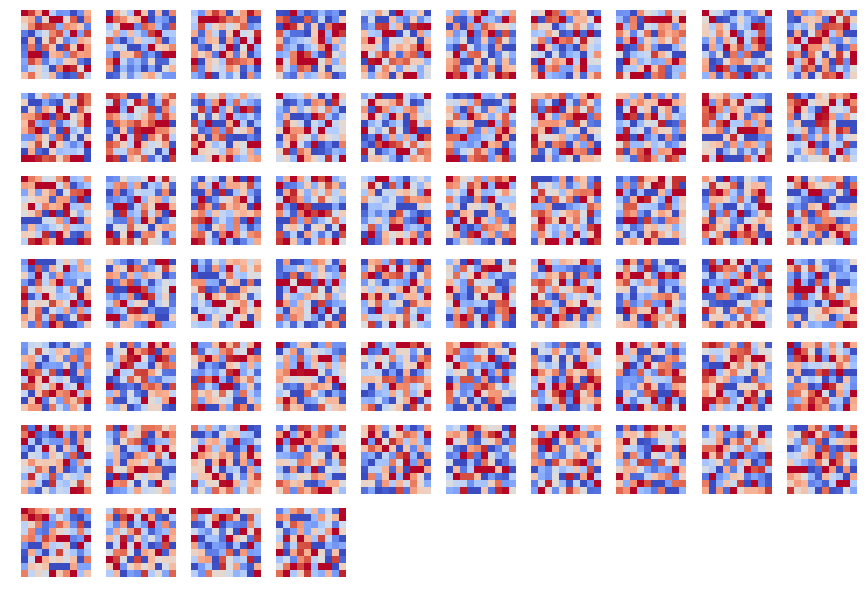

In [202]:
W = model.layers[layer_num].get_weights()[0]
W = W.transpose(3, 2, 0, 1) # 配列を転置する
nb_filter, nb_channel, nb_row, nb_col = W.shape

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.figure()
for i in range(nb_filter):
    im = W[i, 0]
    # 重みを0-255のスケールに変換する
    scaler = MinMaxScaler(feature_range=(0, 255))
    im = scaler.fit_transform(im)
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(im, cmap='coolwarm', interpolation='nearest')
plt.show()

In [73]:
import model
import tensorflow as tf
from tensorflow.contrib.layers import convolution2d, flatten, batch_norm, max_pool2d
from tensorflow.python.ops.nn import relu

def inference(input, labels, is_training, opts):
    """Build the model.

    Args:
        images: images returned from DataGenerator
        labels: labels returned from DataGenerator
        is_training: boolean to set mode for certain layers
        opts: parsed input args
    Returns:
      loss, logits.
    """

    bn1 = batch_norm(input, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn1')
    conv1 = convolution2d(bn1, 32, [3, 3], [1, 1], activation_fn=relu, scope='conv1')
    bn2 = batch_norm(conv1, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn2')
    conv2 = convolution2d(bn2, 32, [3, 3], [1, 1], activation_fn=relu, scope='conv2')
    pool1 = max_pool2d(conv2, kernel_size=[2, 2], stride=[2, 2], scope="pool1")

    bn3 = batch_norm(pool1, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn3')
    conv3 = convolution2d(bn3, 64, [3, 3], [1, 1], activation_fn=relu, scope='conv3')
    bn4 = batch_norm(conv3, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn4')
    conv4 = convolution2d(bn4, 64, [3, 3], [1, 1], activation_fn=relu, scope='conv4')
    pool2 = max_pool2d(conv4, kernel_size=[2, 2], stride=[2, 2], scope="pool2")

    bn5 = batch_norm(pool2, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn5')
    conv5 = convolution2d(bn5, 128, [3, 3], [1, 1], activation_fn=relu, scope='conv5')
    bn6 = batch_norm(conv5, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn6')
    conv6 = convolution2d(bn6, 128, [3, 3], [1, 1], activation_fn=relu, scope='conv6')
    pool3 = max_pool2d(conv6, kernel_size=[2, 2], stride=[2, 2], scope="pool3")

    bn7 = batch_norm(pool3, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn7')
    conv7 = convolution2d(bn7, 256, [3, 3], [1, 1], activation_fn=relu, scope='conv7')
    bn8 = batch_norm(conv7, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn8')
    conv8 = convolution2d(bn8, 256, [3, 3], [1, 1], activation_fn=relu, scope='conv8')
    pool4 = max_pool2d(conv8, kernel_size=[2, 2], stride=[2, 2], scope="pool4")

    #bn9= batch_norm(pool4, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn9')
    #conv9 = convolution2d(bn9, 256, [3, 3], [1, 1], activation_fn=relu, scope='conv9')
    #bn10 = batch_norm(conv9, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn10')
    #conv10 = convolution2d(bn10, 256, [3, 3], [1, 1], activation_fn=relu, scope='conv10')
    #pool5 = max_pool2d(conv10, kernel_size=[2, 2], stride=[2, 2], scope="pool2")

    #bn11= batch_norm(pool5, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn11')
    #conv11 = convolution2d(bn11, 512, [3, 3], [1, 1], activation_fn=relu, scope='conv11')
    #bn12 = batch_norm(conv11, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn12')
    #conv12 = convolution2d(bn12, 512, [3, 3], [1, 1], activation_fn=relu, scope='conv12')
    #pool6 = max_pool2d(conv12, kernel_size=[2, 2], stride=[2, 2], scope="pool2")

    print(pool4.get_shape())
    # fully-connected part as convolutional
    bn13 = batch_norm(pool4, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn13')
    fc1 = convolution2d(bn13, 1024, [3, 3], [1, 1], padding='VALID',activation_fn=relu, scope='fc1')
    print(fc1.get_shape())
    bn14 = batch_norm(fc1, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn14')
    fc2 = convolution2d(bn14, 512, [1, 1], [1, 1], padding='VALID', activation_fn=relu, scope='fc2')
    print(fc2.get_shape())
#    bn15 = batch_norm(fc2, decay=0.9, center=True, scale=True, is_training=is_training, updates_collections=None, scope='bn15')
#    fc3 = convolution2d(bn15, opts.num_classes, [1, 1], [1, 1], padding='VALID', activation_fn=relu, scope='fc3')
    print(fc3.get_shape())

#    for layer in [bn1, conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, fc1, fc2, fc3]:
#        model._activation_summary(layer, opts.tower_name)

ImportError: No module named 'model'

In [72]:
inference(X_train, Y_train, True, 2)

ValueError: Variable bn1/beta already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/Users/daichisato/anaconda/envs/lily/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 217, in variable
    use_resource=use_resource)
  File "/Users/daichisato/anaconda/envs/lily/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "/Users/daichisato/anaconda/envs/lily/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 262, in model_variable
    use_resource=use_resource)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,